# 課題４
１８１００８３　井上悠香

## Loss関数の一つであるSoftmax with lossレイヤー

In [103]:
import numpy as np

#交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1,y.size)
   # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
    
def sigmoid(x):
    return 1/(1+np.exp(-x))

#ソフトマックス関数
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

In [104]:
#Softmaxに入れてその後、交差エントロピー誤差を求めて損失を求めるレイヤ　
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ
        
    def forward(self, x, t):
        self.t = t                  #教師データ
        self.y = softmax(x)#xを代入して確率を出す。
        #損失関数
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self,dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size
        return dx

# Two layer netにおける勾配の確認

In [105]:
#Reluレイヤ
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx
    
#Affineレイヤ
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        self.x = None
        self.original_x_shape = None
       # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None
    def forward(self, x):
       # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

In [109]:
#誤差逆伝播法
#重みパラメータに対する勾配を誤差逆伝播法によって求める
def gradient(network, x, t):
    # 自分で実装したSoftmax with lossクラスを使ってみてください
    lastLayer = network.lastLayer      #networkのSoftmaxwithLossレイヤーを使うのでnetwork.lastlayerを入れる
    self = network                                #ここでのselfはnetwork
    # forward
    #self.loss(x, t)
    network.loss(x, t)
    # backward
    dout = 1
    dout = lastLayer.backward(dout)
    #layers = list(self.layers.values())
    layers = list(network.layers.values())
    layers.reverse()
    for layer in layers:
        dout = layer.backward(dout)
    # 設定
    grads = {}
    #grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W1'], grads['b1'] = network.layers['Affine1'].dW, self.layers['Affine1'].db
    #grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
    grads['W2'], grads['b2'] = network.layers['Affine2'].dW, self.layers['Affine2'].db
    return grads

In [113]:
from collections import OrderedDict

import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *

def numerical_grad(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
    return grad


#勾配を返すTwoLayerNet
class TwoLayerNet:
    #
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
       # 重みの初期化　重みのリストparams
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
       # レイヤの生成  辞書型
        self.layers = OrderedDict()
        #layers['Affine1']は、Affineレイヤに'W1'の重みと'b1'を与えたもの
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        #layers['Relu']は、Reluレイヤ
        self.layers['Relu1'] = Relu()
        #layers['Affine2']は、Affineレイヤに'W2'の重みと'b2'を与えたもの
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        #上のlayersリストとは別にlastLayerにSoftmaxWithLossレイヤを保存
        self.lastLayer = SoftmaxWithLoss() 
        
    def predict(self, x):
        #layersに入っているレイヤーを順番に　　Affine1→Relu→Affine2　出力が次の層の入力
        for layer in self.layers.values():
            x = layer.forward(x)                   #各layerのforward処理していく
        return x
    
    def accuracy(self, x, t):
        y = self.predict(x)
        #np.argmax(最大値を取得したい配列,軸方向)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
          
   # x:入力データ, t:教師データ
    #損失関数
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    #数値微分
    def numerical_gradient(self, x, t):
        #損失関数で求めた値をloss_Wに入れる
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        #重みパラメータに対する勾配を数値微分によって求める
        grads['W1'] = numerical_grad(loss_W, self.params['W1'])
        grads['b1'] = numerical_grad(loss_W, self.params['b1'])
        grads['W2'] = numerical_grad(loss_W, self.params['W2'])
        grads['b2'] = numerical_grad(loss_W, self.params['b2'])
        return grads

In [117]:

#データを読み込んで実行する
import numpy as np
from dataset.mnist import load_mnist
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

#network 　に TwoLayerNetをインスタンス化して処理
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

# 数値微分　ネットワーク
grad_numerical = network.numerical_gradient(x_batch, t_batch)
# Backward
grad_backprop = gradient(network, x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )#順伝播の勾配と逆伝播の勾配の差
    print(key + ":" + str(diff))

W1:2.818318783926189e-13
b1:1.1542968837707778e-12
W2:1.0057510494733673e-12
b2:1.2057022880096468e-10


大きくて$1.1205e^{-10}$という十分小さな値が出力された。出力は、順伝播の勾配と逆伝播の勾配の差であるから、順伝播と逆伝播の勾配にはほとんど違いがないことが確認できた。

今回のエラー<br>

In [ ]:
<ipython-input-73-ef36eae4638b> in backward(self, dout)
     14         return self.loss
     15     def backward(self,dout = 1):
---> 16         batch_size = self.t.shape[0]
     17         dx = (self.y - self.t)/batch_size
     18         return dx

AttributeError: 'NoneType' object has no attribute 'shape' 

NoneTypeオブジェクトとは、Noneタイプのオブジェクトであり、値なしを示すオブジェクトのこと。おそらくCでいうNullのようなもの？<br>
ここでは、softmaxWithLayer の　self.tがNoneTypeと言われている。softmaxWithLayerのtへの代入は、順伝播(forward)で行われている。逆伝播は順伝播がないとできない。softmaxWithLayerは、TwoNetLayerでは、他のレイヤとは、一つだけ別にlastLayerというレイヤに代入されている。（他のレイヤはlayersリストに入っている。）gradientを実行するときにgradientのlastLayerにnetwork.lastLayerを代入しなきゃいけなかった。
参考：[「nonetype」オブジェクトとは何ですか？](https://www.it-swarm.dev/ja/python/%E3%80%8Cnonetype%E3%80%8D%E3%82%AA%E3%83%96%E3%82%B8%E3%82%A7%E3%82%AF%E3%83%88%E3%81%A8%E3%81%AF%E4%BD%95%E3%81%A7%E3%81%99%E3%81%8B%EF%BC%9F/1044227590/)

## Two layer netの学習

0.11916666666666667 0.1168
0.90175 0.9027
0.9225333333333333 0.9239
0.9359666666666666 0.9356
0.9438 0.9433
0.949 0.9462
0.9553 0.9523
0.96045 0.9575
0.9635666666666667 0.9611
0.96715 0.9626
0.96845 0.9643
0.9712666666666666 0.9649
0.9737333333333333 0.9678
0.9745333333333334 0.9681
0.9759666666666666 0.9691
0.9772666666666666 0.9701
0.9782166666666666 0.9703


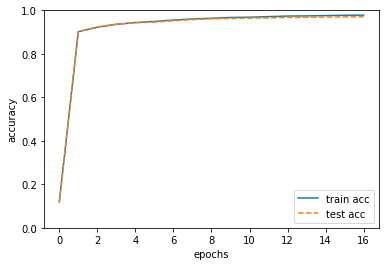

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)
for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
       # 勾配
        #grad = network.numerical_gradient(x_batch, t_batch)
       #grad = gradient(x_batch, t_batch)
        grad = gradient(network, x_batch, t_batch)
       # 更新
        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(train_acc, test_acc)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

前回と同じようにグラフを出力してみた。今回は、誤差逆伝播（gradient）を使用して学習したが、認識精度のグラフは前回と似たような形になった。これは、前の問題で、順伝播の勾配と誤差逆伝播の勾配にほぼ差が無かったことから導かれる結果である。<br>
今回も認識精度は高く、最終的に97パーセントになっている。
参考：[【学習メモ】ゼロから作るDeep Learning【5章】](https://qiita.com/yakof11/items/5d37042f689760515072)